# Simulation of using mean-field dynamics as reservoir

We compute the temporal XOR.

## Dynamics

$$\alpha_r\left(\Theta^t\right) = 
\int_{x}\mathcal{N}\left(x; \mu_r, \sigma_r\right) \prod_{r'\neq r} \Phi\left(x; \mu_{r'}, \sigma_{r'}\right)$$

$$\mu_r = R \sum_{r'} \mu_J(r,r') \Theta_{r'}^t + u_r^t \quad \quad \sigma^2_r = R \sum_{r'} \sigma_J^2(r,r') \Theta_{r'}^t + v_r^t$$

Infinite networks

$$\Theta^{t+1} = \boldsymbol{\alpha}(\Theta^t)$$

Finite networks

$$N\Theta^{t+1} \sim \textrm{Multinomial}\left(\boldsymbol{\alpha}(\Theta^t), N\right)$$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import sys

from disp import set_plot

cc = np.concatenate

In [2]:
# numeric params for computing MF quantities
DX = .05
X_MIN = -30
X_MAX = 30

X = np.linspace(X_MIN, X_MAX, int((X_MAX-X_MIN)/DX)+1)

def norm(x, mu, sgm):
    if sgm == 0:
        temp = np.zeros(X.shape)
        temp[np.argmin(np.abs(X))] = 1/DX
        return temp
    
    return stats.norm.pdf(x, loc=mu, scale=sgm)

def phi(x, mu, sgm):
    if sgm == 0:
        temp = (X >= 0).astype(float)
        temp[X == 0] = .5
        return temp
    
    return stats.norm.cdf(x, loc=mu, scale=sgm)

def alph(th, u, v, R, mu_j, sgm_j):
    """
    th \in [0, 1]^R
    u \in R^R
    v \in R_+^r
    R scalar
    mus \in R^{RxR}
    gams \in R^{RxR}
    """
    mu_r = R*(mu_j @ th) + u
    sgm_r = np.sqrt(R*((sgm_j**2)@th) + v)
    
    phis = np.array([phi(X, mu_r_, sgm_r_) for mu_r_, sgm_r_ in zip(mu_r, sgm_r)])
    
    mnot_r = ~np.eye(len(th), dtype=bool) # masks for selecting all but one r
    
    th_next = np.nan*np.zeros(R)
    for r, (mu_r_, sgm_r_) in enumerate(zip(mu_r, sgm_r)):
        
        mask_r = mnot_r[r]
        th_next[r] = min(np.sum(norm(X, mu_r_, sgm_r_) * np.prod(phis[mask_r, :], axis=0))*DX, 1)
        
    return th_next


In [3]:
t_max = 30
t = np.arange(t_max)

# temporal XOR
us = [np.zeros(t_max) for c in range(4)]
ys = [np.zeros(t_max) for c in range(4)]

start_0 = 2
start_1 = 10
dur = 5

t_targ = 20

us[0][(start_0 <= t)&(t < start_0 + dur)] = -1
us[0][(start_1 <= t)&(t < start_1 + dur)] = -1
ys[0][(t_targ <= t)&(t < t_targ + dur)] = -1

us[1][(start_0 <= t)&(t < start_0 + dur)] = 1
us[1][(start_1 <= t)&(t < start_1 + dur)] = -1
ys[1][(t_targ <= t)&(t < t_targ + dur)] = 1

us[2][(start_0 <= t)&(t < start_0 + dur)] = -1
us[2][(start_1 <= t)&(t < start_1 + dur)] = 1
ys[2][(t_targ <= t)&(t < t_targ + dur)] = 1

us[3][(start_0 <= t)&(t < start_0 + dur)] = 1
us[3][(start_1 <= t)&(t < start_1 + dur)] = 1
ys[3][(t_targ <= t)&(t < t_targ + dur)] = -1

# Random variance couplings

In [4]:
R = 200

mself = np.eye(R, dtype=bool)

MU_J = np.nan*np.zeros((R, R))

MU_J[mself] = 0
MU_J[~mself] = 0

SGM_J = np.zeros((R, R))
SGM_J[mself] = 1

for r in range(R):
    choices = list(range(R))
    choices.pop(r)
    idxs = np.random.choice(choices, 10)
    SGM_J[r, idxs] = .5

## Inputs

In [5]:
w_in = np.zeros(R)
w_in[np.random.permutation(R)[:50]] = 1

........

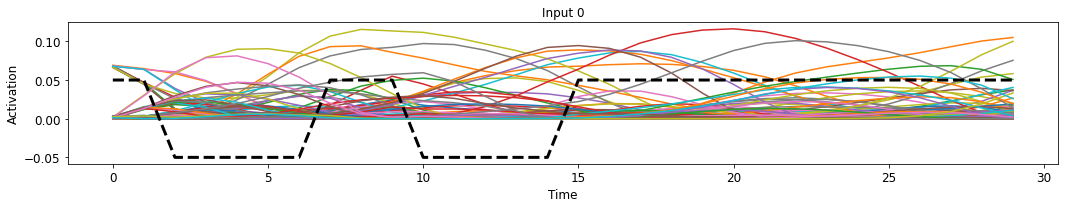

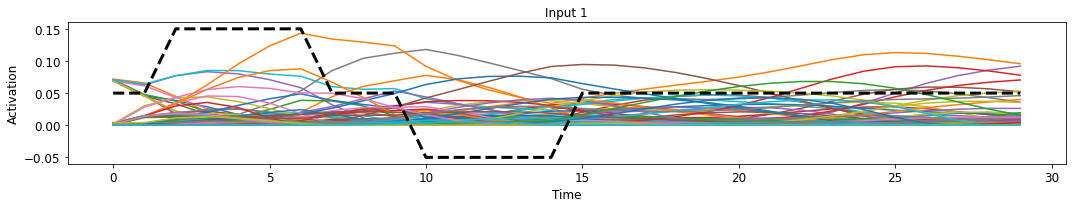

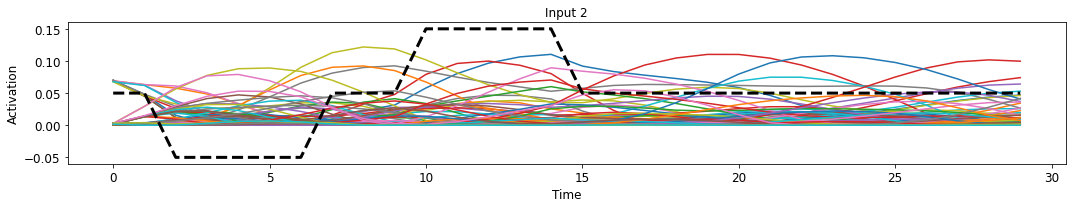

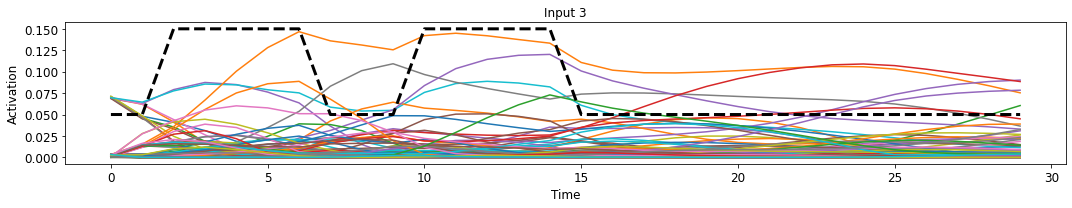

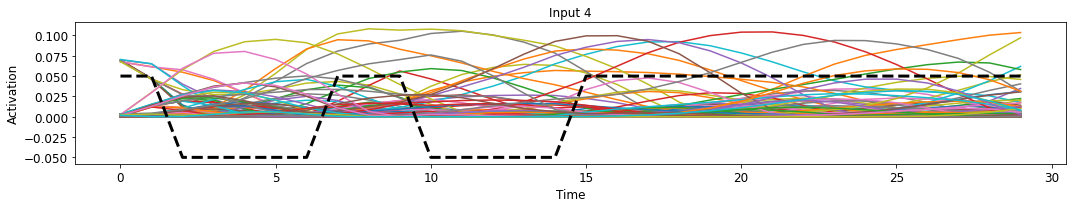

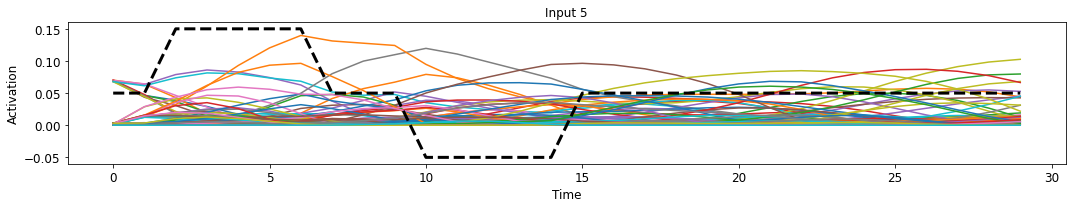

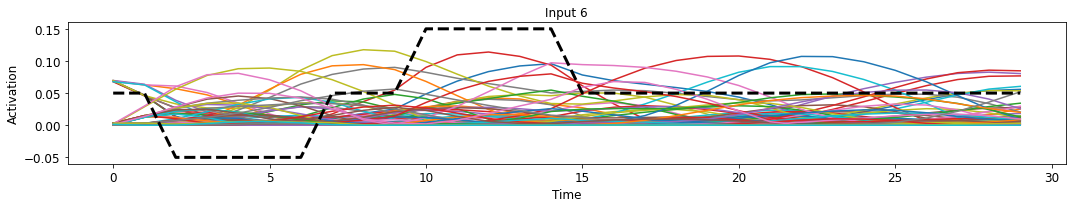

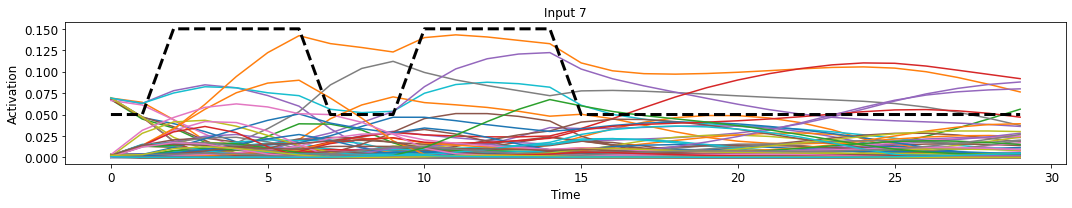

In [6]:
ths_all = []

for cu, u in enumerate(2*us):
    sys.stdout.write('.')

    th_0 = np.random.rand(R)*.05
    th_0[:10] += 1
    th_0 /= th_0.sum()

    ths = np.nan*np.zeros((t_max, R))
    ths[0, :] = th_0

    for t_ in t[1:]:
        ths[t_, :] = alph(ths[t_-1, :], u=u[t_]*w_in, v=0, R=R, mu_j=MU_J, sgm_j=SGM_J)
        if np.any(np.isnan(ths[t_, :])):
            raise Exception

    ths_all.append(ths)
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 3), tight_layout=True)
    ax.plot(t, ths)
    ax.plot(t, u/10+.05, c='k', lw=3, ls='--')
    set_plot(ax, x_label='Time', y_label='Activation', title=f'Input {cu}')

In [7]:
from sklearn.linear_model import Ridge

ALPH = .001

In [8]:
ndim = R
rgr = Ridge(alpha=ALPH).fit(cc(ths_all[:4])[:, :ndim], cc(ys))
w = rgr.coef_
y_hats = [rgr.predict(ths[:, :ndim]) for ths in ths_all]

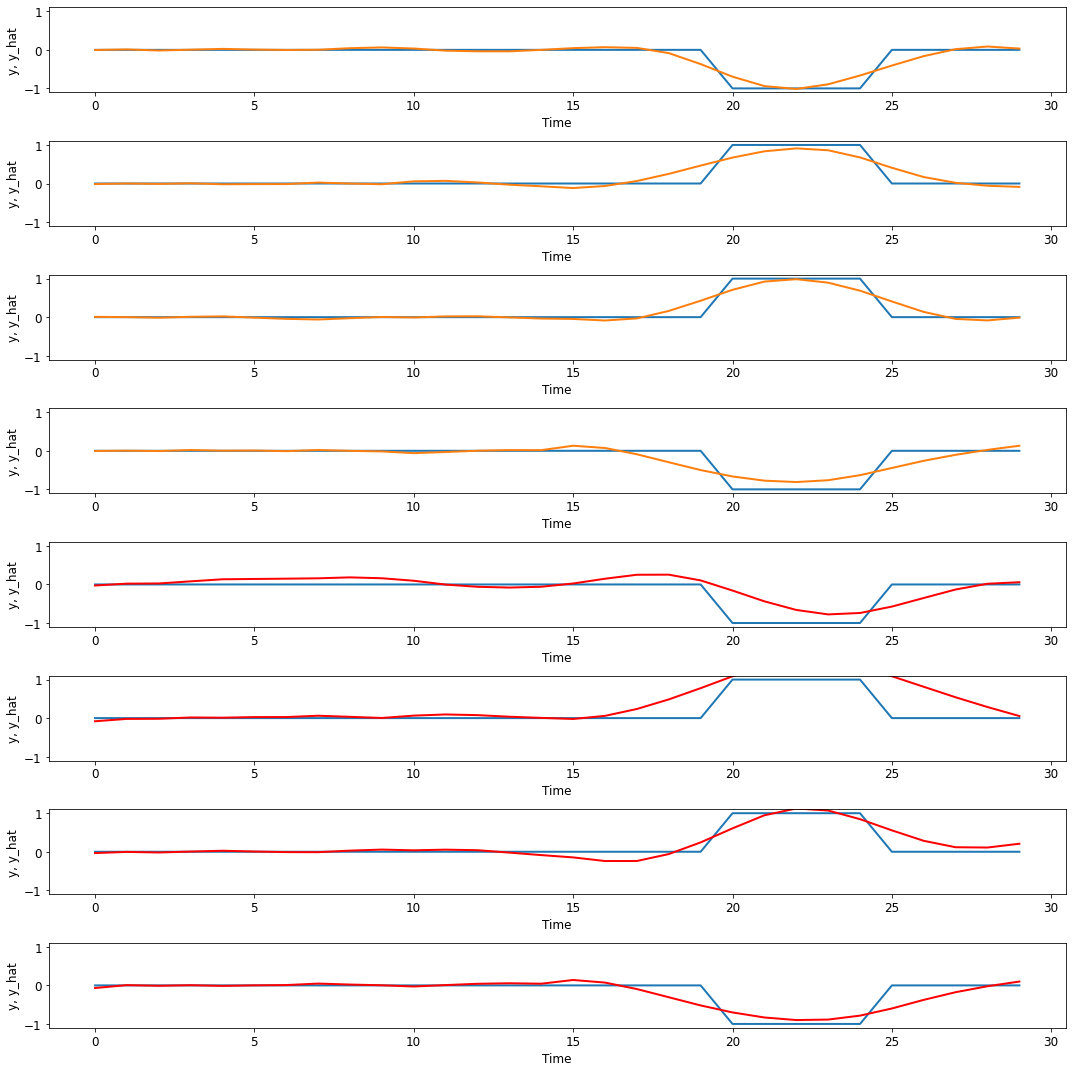

In [9]:
fig, axs = plt.subplots(8, 1, figsize=(15, 15), tight_layout=True)

for ax, u, y, y_hat in zip(axs, us, ys, y_hats[:4]):
    ax.plot(t, y, lw=2)
    ax.plot(t, y_hat, lw=2)

    set_plot(ax, y_lim=(-1.1, 1.1), x_label='Time', y_label='y, y_hat')
    
for ax, u, y, y_hat in zip(axs[4:], us, ys, y_hats[4:]):
    ax.plot(t, y, lw=2)
    ax.plot(t, y_hat, lw=2, c='r')

    set_plot(ax, y_lim=(-1.1, 1.1), x_label='Time', y_label='y, y_hat')